# Logical qubit encoding with 5 qubits

In this notebook we encode and decode a logical qubit in 5 physical qubits,
which is the minimal number required to detect arbitrary single qubit errors.
Note that this code can only detect single errors happening on single qubits.
Error correction can be performed by measuring error syndromes after decoding.
For more information see the references:

**References**

1. Zhang, J., Laflamme, R. & Suter, D.
    Experimental implementation of encoded logical qubit operations in a perfect quantum error correcting code.
    Phys. Rev. Lett. 109, 100503 (2012).
    [Link to pdf](https://arxiv.org/pdf/1208.4797.pdf)

2. Laflamme, R., Miquel, C., Paz, J. P. & Zurek, W. H.
    Perfect Quantum Error Correction Code.
    arXiv:quant-ph/9602019 (1996).
    [Link to pdf](https://arxiv.org/pdf/quant-ph/9602019.pdf)

3. Knill, E., Laflamme, R., Martinez, R. & Negrevergne, C.
    Benchmarking Quantum Computers: The Five-Qubit Error Correcting Code.
    Phys. Rev. Lett. 86, 5811–5814 (2001).
    [Link to pdf](https://www.researchgate.net/publication/11925577_Benchmarking_Quantum_Computers_The_Five-Qubit_Error_Correcting_Code)

Code: Pieter Eendebak pieter.eendebak@tno.nl, Olexiy Fedorets o.o.fedorets@student.tudelft.nl

Based on work by: Nathan van Beugen, Jord Molhoek, Dan Andreescu, Sergi van den Berg, Stein Fakkel

To install the required dependencies for this notebook run:

    pip install qiskit rich

### Load packages and define some helper methods.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit
from IPython.display import Latex, Markdown, display
from qiskit import Aer, execute
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.extensions import UnitaryGate
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.transpiler import PassManager
from qiskit.utils import QuantumInstance

try:
    from rich import pretty, print
    pretty.install()
except:
    pass


def calculate_unitary(circ: QuantumCircuit, decimals=3) -> np.ndarray:
    """ Calculate unitary matrix from circuit """
    backend = Aer.get_backend("unitary_simulator")
    job = execute(circ, backend)
    result = job.result()

    U = result.get_unitary(circ, decimals=decimals)
    return U


def format_float_dict(d, decimals: int = 8):
    """ Format dictionary by rounding floating point values """

    def format(value):
        if np.abs(value) < 1e-8:
            return 0
        return np.round(value, decimals)

    formatted = {key: format(value) for key, value in d.items()}
    return formatted


def printmd(string, color=None):
    """ Display string as markdown. """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### Define encoder and decoder

We generate two methods to define the encoder and decoder.
Note that here the center qubit (third qubit q[2]) is being encoded using the outer qubits.

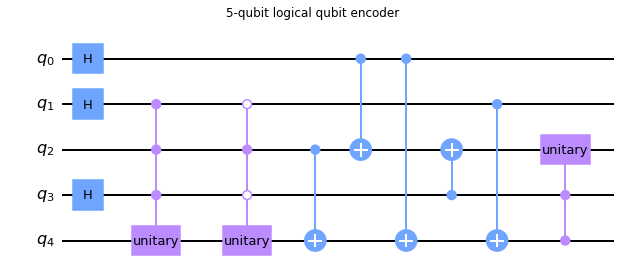

In [2]:
def generate_encoder() -> QuantumCircuit:
    """Generate the 5-qubit logical qubit encoder.
    Here the third (center) qubit q[2] is being used to encode the state.

    Returns:
        The circuit to encode a logical qubit in 5 physical qubits as a qiskit QuantumCircuit object.
    """
    qc = QuantumCircuit(5, name="encoder")

    qc.h(0)
    qc.h(1)
    qc.h(3)

    p_gate = UnitaryGate([[-1, 0], [0, -1]])
    cmulti_z_gate0 = p_gate.control(3)
    cmulti_z_gate1 = p_gate.control(3, ctrl_state="010")
    cmulti_z_gate2 = p_gate.control(2)

    qc.append(cmulti_z_gate0, [1, 2, 3, 4])
    qc.append(cmulti_z_gate1, [1, 2, 3, 4])

    qc.cx(2, 4)
    qc.cx(0, 2)
    qc.cx(0, 4)
    qc.cx(3, 2)
    qc.cx(1, 4)
    qc.append(cmulti_z_gate2, [4, 3, 2])

    return qc


def generate_decoder() -> QuantumCircuit:
    """Generate the 5-qubit logical qubit encoder.
    The decoder is the inverse (hermitian conjugate) circuit of the encoder.

    Returns: QuantumCircuit
        The circuit to decode a logical qubit encoded in 5 physical qubits as a qiskit QuantumCircuit object.
    """
    encoder = generate_encoder()
    decoder = encoder.inverse()
    return decoder


encoder = generate_encoder()
decoder = generate_decoder()

plt.title("5-qubit logical qubit encoder")
circuit_drawer(encoder, output="mpl", ax=plt.gca())  # TODO fix plotting

## Generate state vector for $|0_{L} \rangle$ and $|1_{L} \rangle$

In [3]:
simulator = Aer.get_backend("statevector_simulator")

qc = QuantumCircuit(5, 5, name="Laflamme encoder on |0>")
qc = qc.compose(generate_encoder())

logical_zero_result = execute(qc, simulator).result()
statevector = logical_zero_result.get_statevector(qc)
sv = Statevector(statevector)

printmd("__Logical zero__", color="green")
print("State vector:")
display(np.round(np.real_if_close(statevector), 14) + 0)
display(Latex(r"$|0_{L} \rangle$"), sv.draw("latex"))
print(f"probabilities for states: \n" + str(format_float_dict(sv.probabilities_dict())))

qc = QuantumCircuit(5, 5, name="Laflamme encoder on |1>")
qc.x(2)
qc = qc.compose(generate_encoder())

logical_one_result = execute(qc, simulator).result()
statevector = logical_one_result.get_statevector(qc)
sv = Statevector(statevector)

printmd("__Logical one__", color="green")
print("State vector:")
display(np.round(np.real_if_close(statevector), 14) + 0)
print(f"probabilities for states: \n" + str(format_float_dict(sv.probabilities_dict())))
display(Latex(r"$|1_{L} \rangle$"), sv.draw("latex"))

<span style='color:green'>__Logical zero__</span>

State vector:

array([ 0.35355339,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.35355339,  0.        ,  0.        ,
        0.        ,  0.35355339,  0.35355339,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.35355339,  0.        ,
        0.        ,  0.35355339,  0.        ,  0.        ,  0.        ,
       -0.35355339,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.35355339,  0.        ])

probabilities for states: 
{'00000': 0.125, '00111': 0.125, '01011': 0.125, '01100': 0.125, '10010': 0.125, '10101': 
0.125, '11001': 0.125, '11110': 0.125}

<span style='color:green'>__Logical one__</span>

State vector:

array([ 0.        , -0.35355339,  0.        ,  0.        ,  0.        ,
        0.        ,  0.35355339,  0.        ,  0.        ,  0.        ,
       -0.35355339,  0.        ,  0.        ,  0.35355339,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.35355339,
       -0.35355339,  0.        ,  0.        ,  0.        , -0.35355339,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.35355339])

probabilities for states: 
{'00001': 0.125, '00110': 0.125, '01010': 0.125, '01101': 0.125, '10011': 0.125, '10100': 
0.125, '11000': 0.125, '11111': 0.125}

The encodings differ from [Ref. 1](https://arxiv.org/pdf/1208.4797.pdf) (equations 2 and 3).
There are errors in the original paper (confirmed by the authors).

## Test encoder - decoder

First apply encoding - decoding  without any errors

In [4]:
qc = QuantumCircuit(5, 5, name="Laflamme logical qubit")

qc.compose(encoder, inplace=True)
qc.barrier()

qc.compose(decoder, inplace=True)
qc.barrier()
qc.measure([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

simulator = Aer.get_backend("qasm_simulator")

result = execute(qc, simulator, shots=100).result()
counts = result.get_counts()
print(f"syndrome counts: {counts}")

syndrome counts: {'00000': 100}

The result is as expected: we always have the same measurement result with syndrome 0000.
This indicates no error, so no corrections are required.

Next we apply a single error after encoding, but before decoding: a bit flip on the first qubit.

syndrome counts: {'01010': 100}

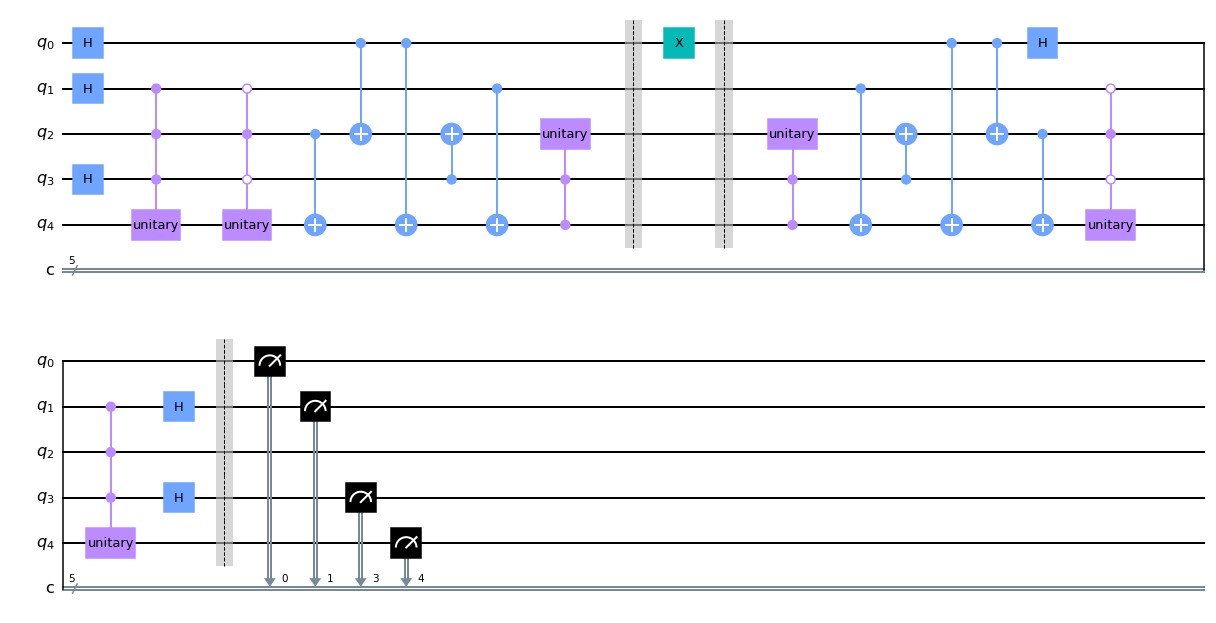

In [6]:
qc = QuantumCircuit(5, 5, name="Laflamme logical qubit")

qc.compose(encoder, inplace=True)
qc.barrier()

# apply a bit flip error on the first qubit
qc.x(0)
qc.barrier()
qc.compose(decoder, inplace=True)
qc.barrier()
qc.measure([0, 1, 3, 4], [0, 1, 3, 4])

simulator = Aer.get_backend("qasm_simulator")

result = execute(qc, simulator, shots=100).result()
counts = result.get_counts()
print(f"syndrome counts: {counts}")
circuit_drawer(qc, output="mpl");

We are able to detect the error via a syndrome in the final measurement!
This error syndrome corresponds to B1 from Table 1 in [Ref. 2](https://arxiv.org/pdf/quant-ph/9602019.pdf).
Note that since we encode q[2], the third number of the measurement result is not included in the syndrome,
which therefore is just '0110'.

## Syndrome measurement and correction

### Mapping of error syndromes and corrections

Now we want to also correct the errors that we are detecting.
To do that, we first define a mapping from all syndrome measurements to the required corrections.
See [Ref. 2](https://arxiv.org/pdf/quant-ph/9602019.pdf) Table 1.

In [7]:
error_correction_matrices = [
    [[1, 0], [0, 1]],  # Identity
    [[0, -1], [1, 0]],  # bit flip and sign alpha
    [[-1, 0], [0, 1]],  # sign alpha
    [[1, 0], [0, -1]],  # phase flip
    [[-1, 0], [0, -1]],  # sign flip
    [[0, -1], [-1, 0]],  # bit and sign flip
]

op = [Operator(m) for m in error_correction_matrices]
print(error_correction_matrices)

# Bit string received from measurement above is mirrored,
# and includes a zero by default for q[2] since it is used to encode the state.
# The values below are therefore: [q[4],q[3],0,q[1],q[0]]
syndrome_inverted = {
    0b00000: op[0],
    0b10011: op[1],
    0b11011: op[2],
    0b10000: op[3],
    0b01001: op[3],
    0b00011: op[3],
    0b10010: op[3],
    0b11000: op[4],
    0b00001: op[4],
    0b00010: op[4],
    0b01000: op[4],
    0b01010: op[5],
    0b11010: op[5],
    0b11001: op[5],
    0b01011: op[5],
    0b10001: op[5],
}
print(syndrome_inverted)

[
    [[1, 0], [0, 1]],
    [[0, -1], [1, 0]],
    [[-1, 0], [0, 1]],
    [[1, 0], [0, -1]],
    [[-1, 0], [0, -1]],
    [[0, -1], [-1, 0]]
]

{
    0: Operator([[1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    19: Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    27: Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    16: Operator([[ 1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    9: Operator([[ 1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    3: Operator([[ 1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    18: Operator([[ 1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    24: Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    1: Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    2: Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    8: Operator([[-1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    10: Operator([[ 0.+0.j, -1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    26: Operator([[ 0.+0.j, -1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    25: Operator([[ 0.+0.j, -1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    11: Operator([[ 0.+0.j, -1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,)),
    17: Operator([[ 0.+0.j, -1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))
}

We combine the components to the full circuit:

__encoder -- random error -- decoder -- syndrome measurement -- error correction__

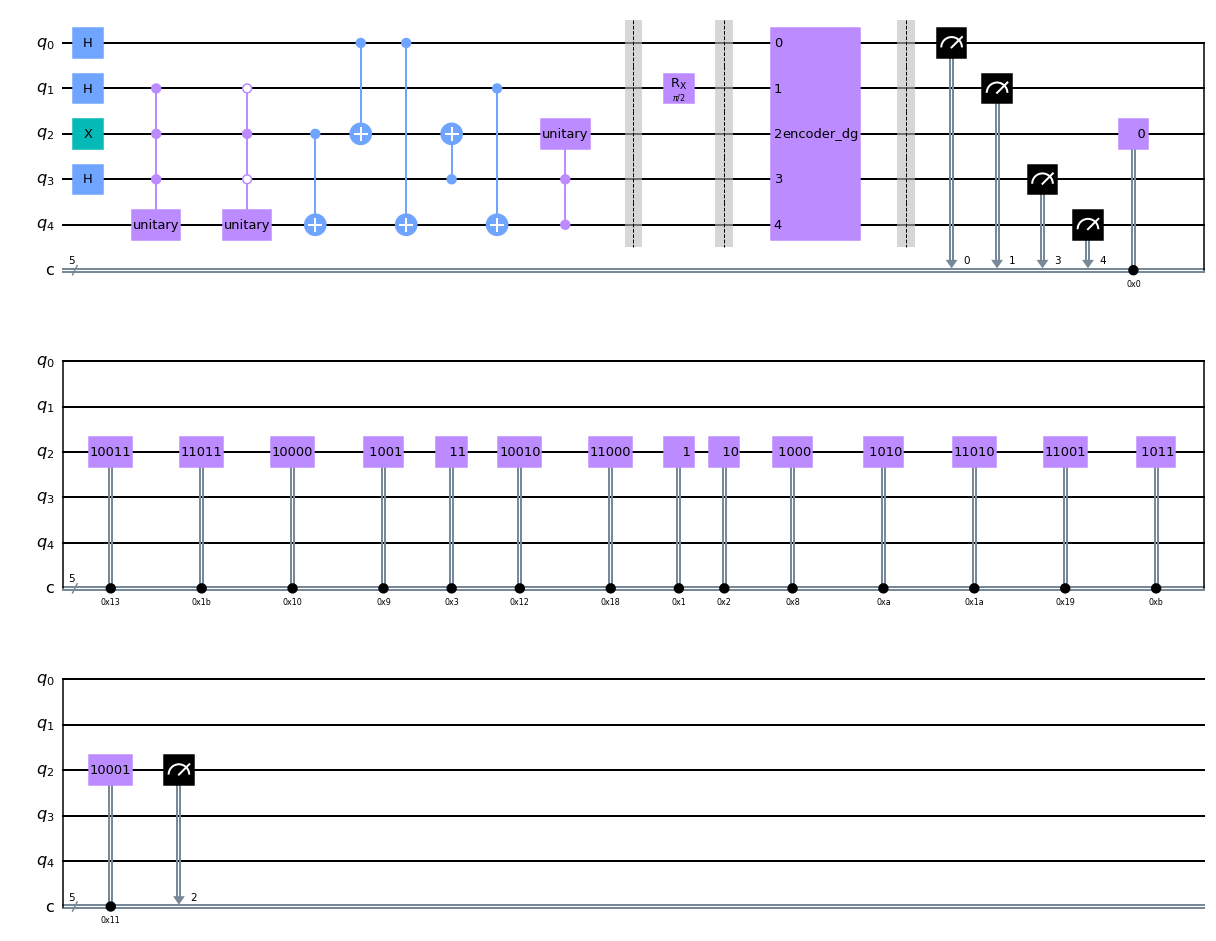

In [8]:
nbits = 5
q = QuantumRegister(nbits, "q")
c = ClassicalRegister(nbits, "c")
qc = QuantumCircuit(q, c, name="Laflamme logical qubit")

# set input state to |1>
qc.x(2)

qc.compose(generate_encoder(), inplace=True)
qc.barrier()

# apply error on qubit 1
qc.rx(np.pi / 2, 1)

qc.barrier()
qc.append(generate_decoder(), range(5))
qc.barrier()
qc.measure([0, 1, 3, 4], [0, 1, 3, 4])

for key in syndrome_inverted:
    operator = syndrome_inverted.get(key)
    label = str(f"{key:5b}")
    # Apply operator if inverted error syndrome equals value of classical (c-) register
    qc.unitary(operator, [2], label=str(f"{key:5b}")).c_if(c, key)

# Measure qubit 2, so we can know if it is indeed the same as before the whole circuit
qc.measure(2, 2)

circuit_drawer(qc, output="mpl");

In [9]:
simulator = Aer.get_backend("qasm_simulator")

result = execute(qc, simulator, shots=100).result()
counts = result.get_counts()
print(counts)

{'00100': 50, '10100': 50}

As we see in the final measurement result, we recover qubit 2 being in the $|1\rangle$-state

## Logical qubit performance on a real, noisy device

We will now investigate the feasibility of performing this type of logical qubit encoding on a real, noisy device like the _Quantum Inspire_ [_Starmon-5_](https://www.quantum-inspire.com/backends/starmon-5/).
To do that, usually the first thing to check is comparing the result of performing the encoding and decoding of the logical qubit to just letting the qubits idle for the same amount of time.

First we will construct a Qiskit noise model, taking into account (approximate) coherence times and gate errors of the device.
We will also be using a Qiskit `QuantumInstance` to run the simulations in this section, as it is necessary to include noise in a simulation of an idling (identity) circuit.

In [12]:
# T1/T2, gate duration and gate errors from Starmon-5
T1 = 20e-6
T2 = 20e-6
T_1Qgate = 20e-9
T_2Qgate = 60e-9
p1Q = 0.005
p2Q = 0.01
noise_model = NoiseModel()

# Noise on real circuit
# Rz gates can be performed as perfect virtual-Z in software (by changing the phase of all subsequent gates)
# so we do not add noise on them
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(T1, T2, T_1Qgate), "rx")
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(T1, T2, T_1Qgate), "ry")
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_error(T1, T2, T_2Qgate).tensor(thermal_relaxation_error(T1, T2, T_2Qgate)), "cz"
)
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), "rx")
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), "ry")
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), "cz")

# Noise for the idling circuit
noise_model.add_basis_gates(["delay"])
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_error(T1, T2, T_1Qgate, excited_state_population=0), ["delay"]
)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'cz', 'delay', 'id', 'rx', 'ry', 'u3']
  Instructions with noise: ['ry', 'delay', 'cz', 'rx']
  All-qubits errors: ['rx', 'ry', 'cz', 'delay']

In [13]:
qc_logical = QuantumCircuit(5, 5, name="Laflamme logical qubit")
# set input state to |1>
qc_logical.x(2)
qc_logical.compose(encoder, inplace=True)
qc_logical.barrier()
qc_logical.compose(decoder, inplace=True)
qc_logical.barrier()
qc_logical.measure_all()  # ([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

Circuit depth:  17

Number of gates: 
OrderedDict([('cx', 10), ('h', 6), ('measure', 5), ('c-unitary', 4), ('barrier', 3), 
('c-unitary_o2', 2), ('x', 1)])

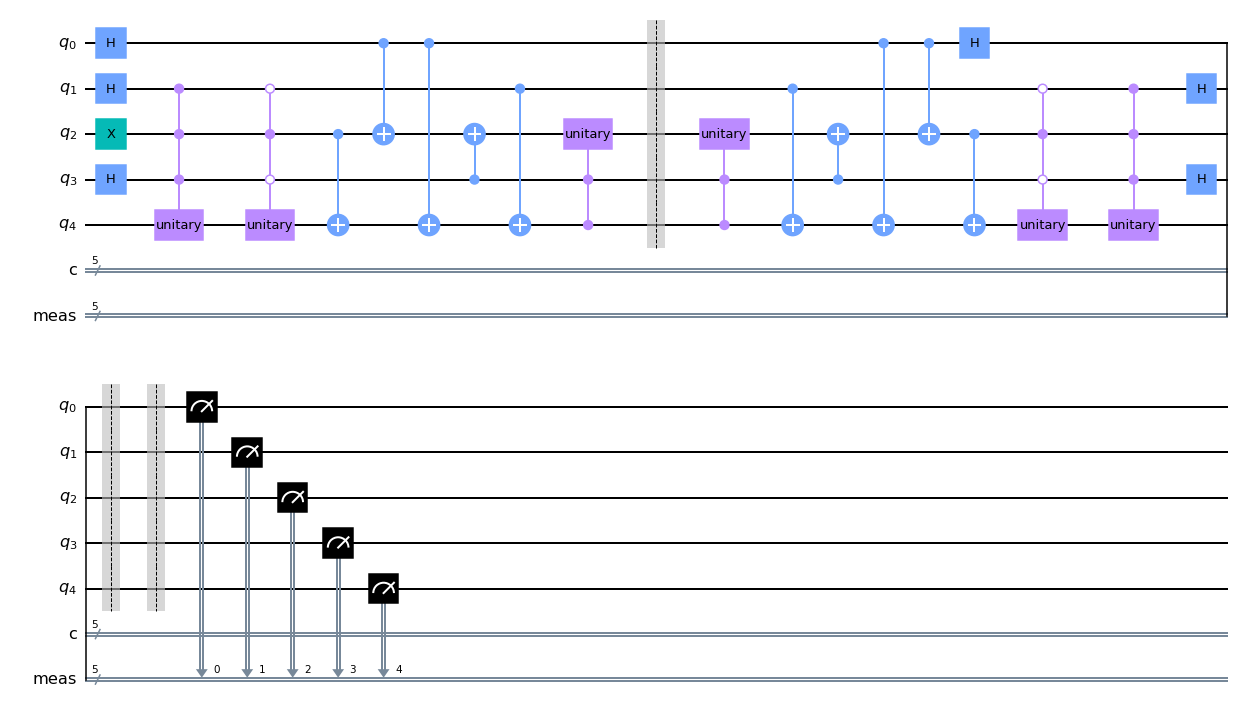

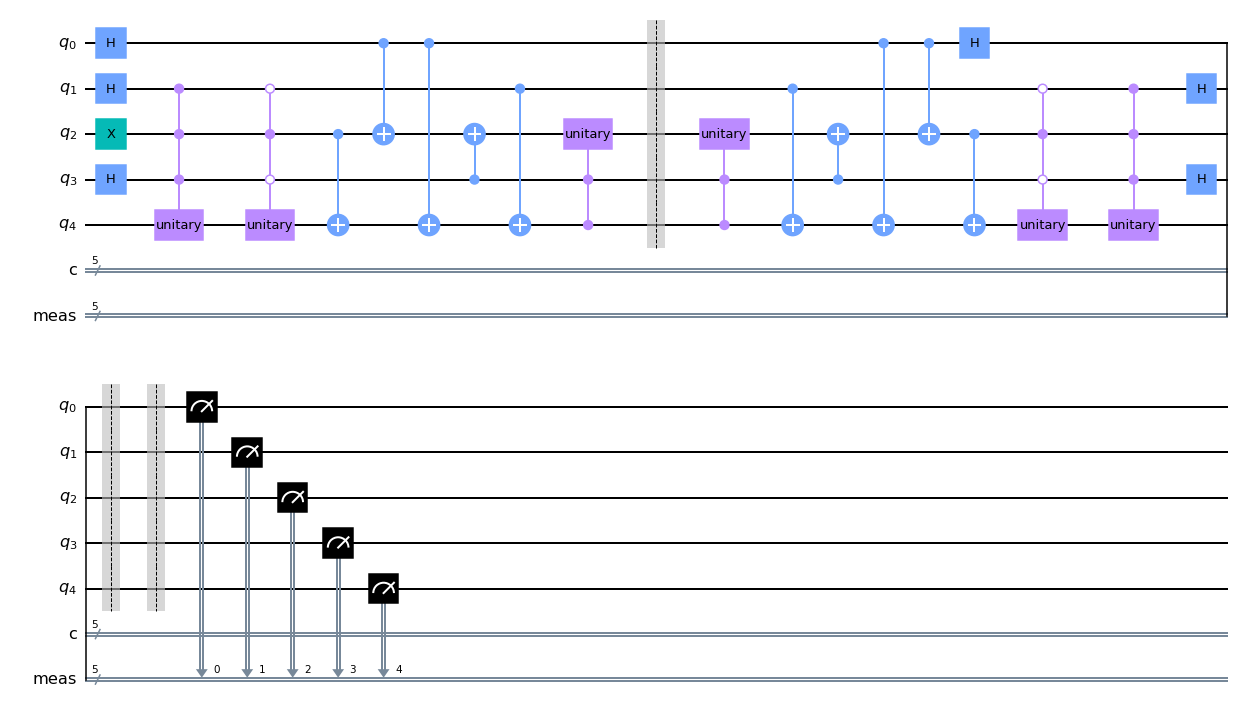

In [14]:
print("Circuit depth: ", qc_logical.depth())
print("Number of gates: ", qc_logical.count_ops())
circuit_drawer(qc_logical, output="mpl")

### Transpile circuit into native gate set of the _Starmon-5_ and simulate the result using the `QuantumInstance` object

Notice how the circuit depth blows up in comparison to the high-level circuit.
This is largely due to the multi-controlled unitaries that we used for logical encoding/decoding, which need to be transpiled to the native gate set of the hardware.
For example, to implement a [_Toffoli_](https://www.quantum-inspire.com/kbase/toffoli/) _gate_ (controlled-controlled-not) it takes at least 6 two qubit gates in general.

Circuit depth:  145

Number of gates: 
OrderedDict([('cz', 78), ('rz', 60), ('rx', 41), ('ry', 32), ('measure', 5), ('barrier', 3)])

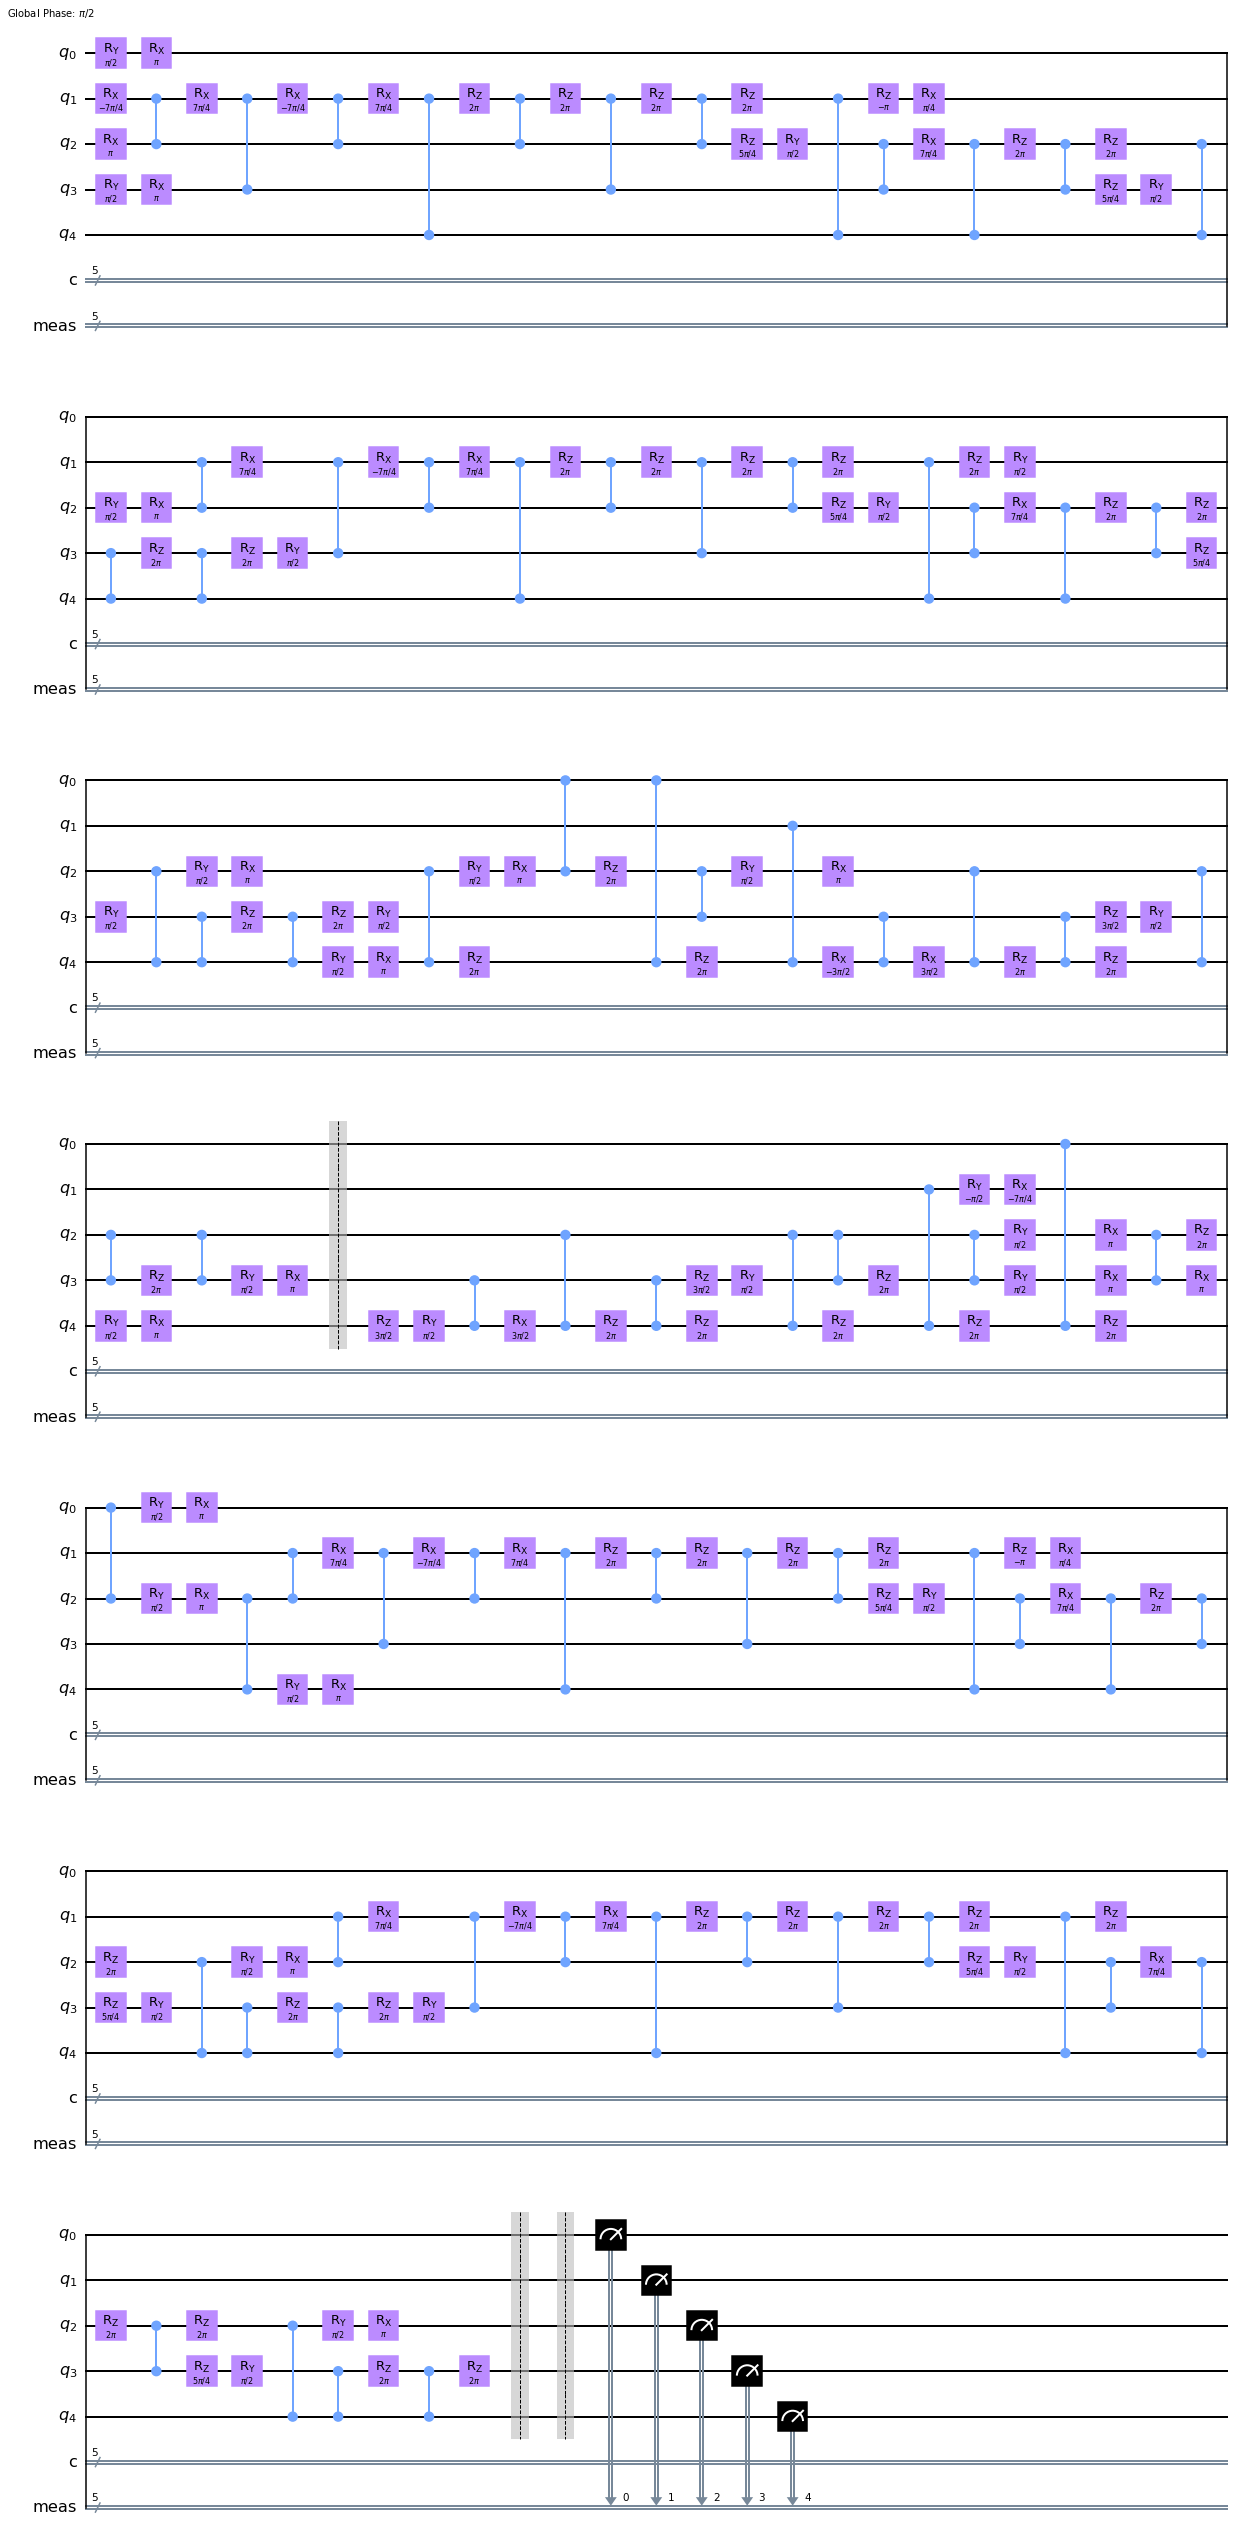

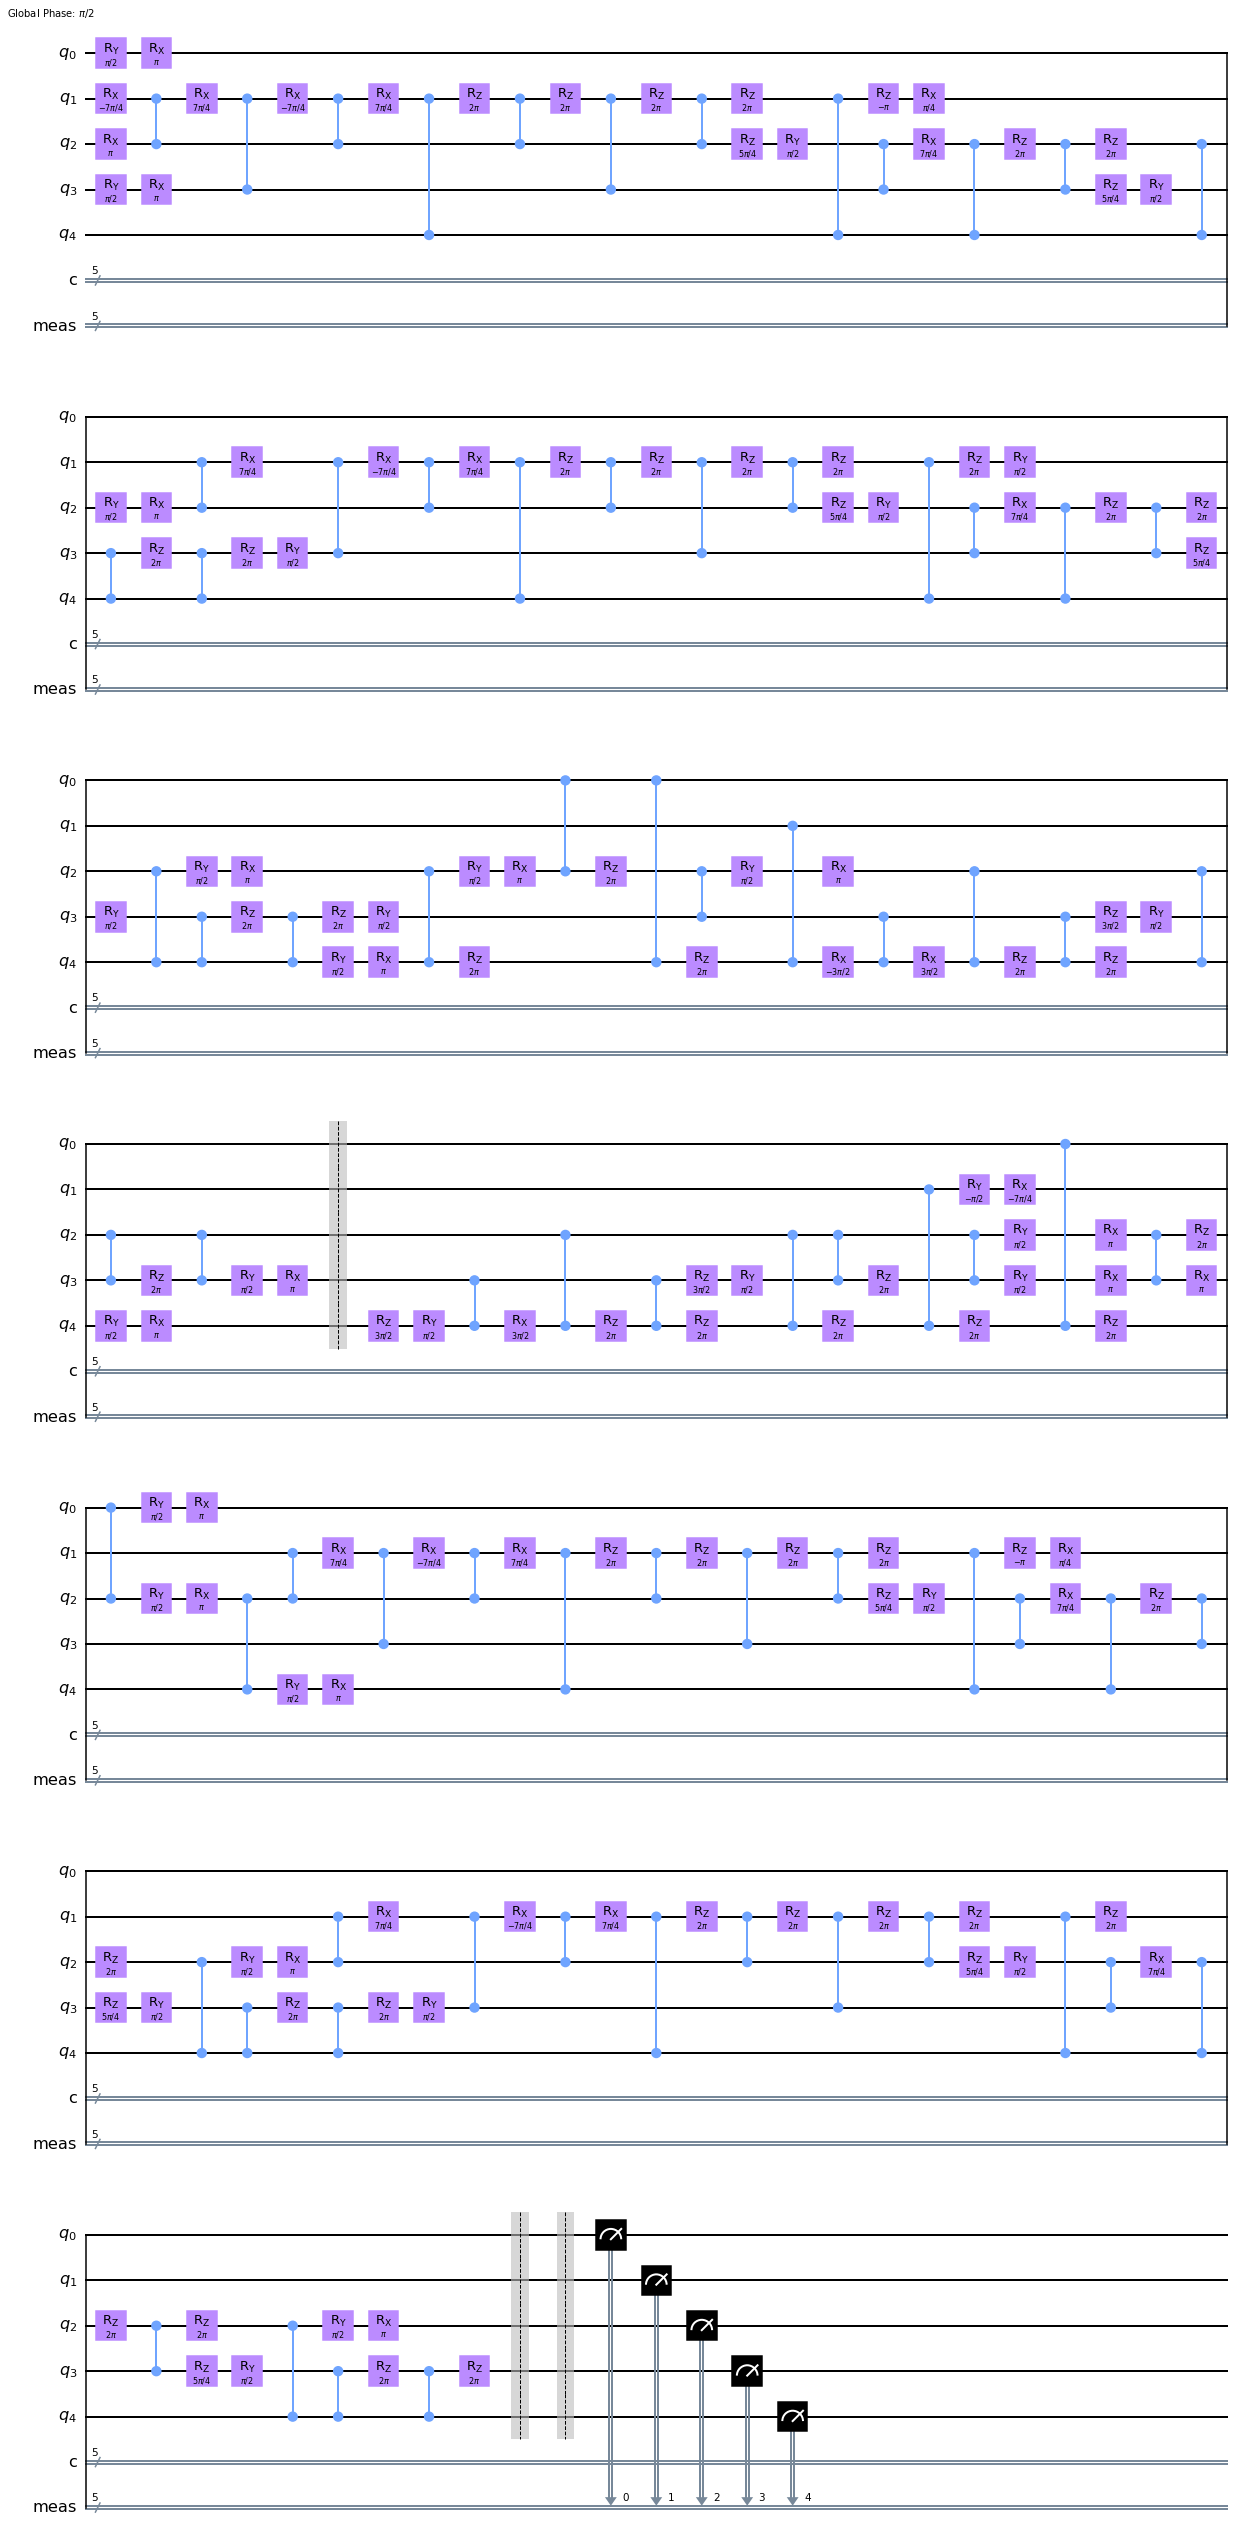

In [15]:
qc_transpiled = qiskit.transpile(qc_logical, basis_gates=["rx", "ry", "rz", "cz"])
print("Circuit depth: ", qc_transpiled.depth())
print("Number of gates: ", qc_transpiled.count_ops())
circuit_drawer(qc_transpiled, output="mpl")

In [18]:
quantum_instance = QuantumInstance(
    backend=Aer.get_backend("aer_simulator_statevector"),
    basis_gates=["cz", "rx", "ry", "rz", "mygate"],
    optimization_level=0,
    pass_manager=PassManager(),
    noise_model=noise_model,
    shots=200,
)
result = quantum_instance.execute(qc_transpiled)

{'11010 00000': 2, '10110 00000': 4, '01001 00000': 1, '01101 00000': 4, '00100 00000': 33, 
'11110 00000': 2, '10010 00000': 2, '11011 00000': 1, '10111 00000': 1, '11001 00000': 3, 
'11111 00000': 2, '10001 00000': 3, '10100 00000': 5, '10011 00000': 1, '11101 00000': 1, 
'01000 00000': 1, '11000 00000': 3, '00001 00000': 2, '00110 00000': 4, '01110 00000': 7, 
'00010 00000': 4, '00000 00000': 4, '01010 00000': 1, '00101 00000': 1, '01100 00000': 3, 
'01111 00000': 1, '10000 00000': 2, '01011 00000': 2}

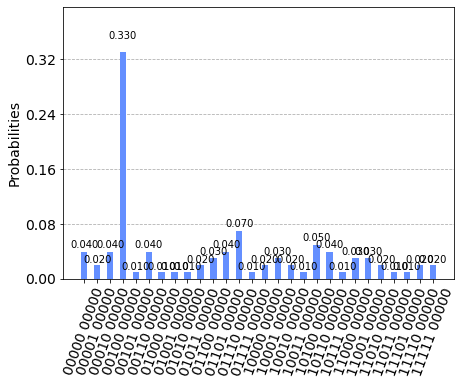

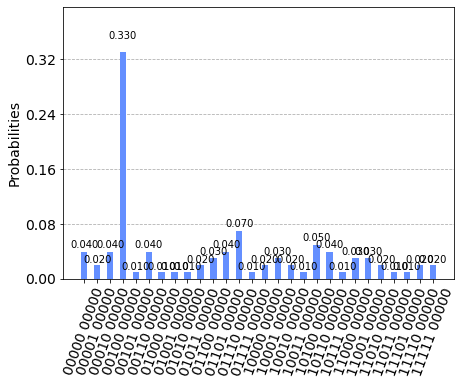

In [19]:
counts = result.get_counts()
print(counts)
plot_histogram(counts)

It is evident that under real conditions, the circuit performs much worse.
However we can still recover the input $|1_{L} \rangle$-state by the highest probability of measurement.

### Prepare a circuit where all qubits idle for the same amount of time as it takes to execute the logical encoder-decoder

Using `circuit.count_ops()` we can know exactly how many and what kind of gates are being used,
and can program the qubits to idle as long as they last.
Note that this is in general overestimate of the execution time, as gates can and are being scheduled in parallel on a real device.
Looking at the transpiled circuit above, we see that no two-qubit gates can happen in parallel,
and on average about two single-qubit gates are executed simultaneously (excluding virtual-Z gates).
This already gives a good approximation of the true execution time.

We have to be careful, since the noise model can only take a single duration for all delay gates,
regardless of their own duration, and will apply noise according relaxation and dephasing noise according to that.
Therefore to model two-qubit gates, we need add 3 delay gates for each.

In [26]:
transpiled_gates = qc_transpiled.count_ops()

# ID = UnitaryGate(np.eye(2), label='mygate')
qc_idle = QuantumCircuit(5, 5, name="Idle circuit")
# set input state to |1>
qc_idle.x(2)
# let other qubits idle in superposition
qc_idle.rx(np.pi / 2, [0, 1, 3, 4])

for gate in range(3 * transpiled_gates["cz"]):
    qc_idle.delay(T_1Qgate, unit="s")

# Note again that Rz's are virtual
for gate in range(int(0.5 * (transpiled_gates["rx"] + transpiled_gates["ry"]))):
    qc_idle.delay(T_1Qgate, unit="s")

qc_idle.rx(-np.pi / 2, [0, 1, 3, 4])
qc_idle.measure_all()
# circuit_drawer(qc_idle, output='mpl');

In [24]:
quantum_instance = QuantumInstance(
    backend=Aer.get_backend("aer_simulator_statevector"),
    basis_gates=["cz", "rx", "ry", "rz", "mygate", "delay"],
    optimization_level=0,
    pass_manager=PassManager(),
    noise_model=noise_model,
    shots=200,
)
result = quantum_instance.execute(qc_idle)

{'10000 00000': 4, '10100 00000': 14, '00100 00000': 90, '01110 00000': 3, '00000 00000': 31,
'00001 00000': 8, '10101 00000': 3, '00101 00000': 10, '01100 00000': 14, '00110 00000': 5, 
'10110 00000': 3, '11100 00000': 1, '01000 00000': 5, '01101 00000': 2, '00111 00000': 3, 
'11000 00000': 1, '10001 00000': 1, '01001 00000': 1, '00010 00000': 1}

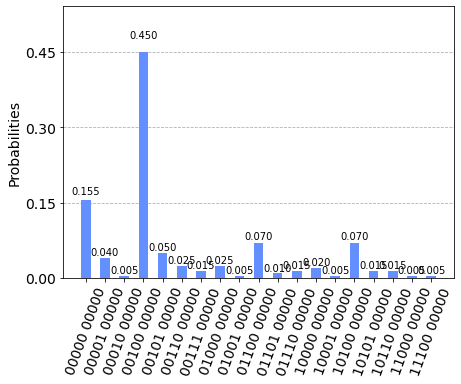

In [25]:
print(result.get_counts())
plot_histogram(result.get_counts());

Also for this circuit it is clear that even just by letting the qubits idle in superposition,
the measurement result is far from perfect.
The distribution of probabilities is similar to the logical qubit circuit,
but the probability to recover the $|1_{L} \rangle$-state is slightly higher.
This is however **highly dependent on the exact parameters of the noise model we have chosen**.
We can conclude from this experiment that it may not be absolutely advantageous to perform this type of logical encoding on current hardware.